In [1]:
# estimate the onset of coronavirus outbreak and peak number of confirmed cases

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.plotting.register_matplotlib_converters()

# confirmed cases are expected to be monotonically increasing, but they are not
data_source = "../data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"

source_df = pd.read_csv(data_source)


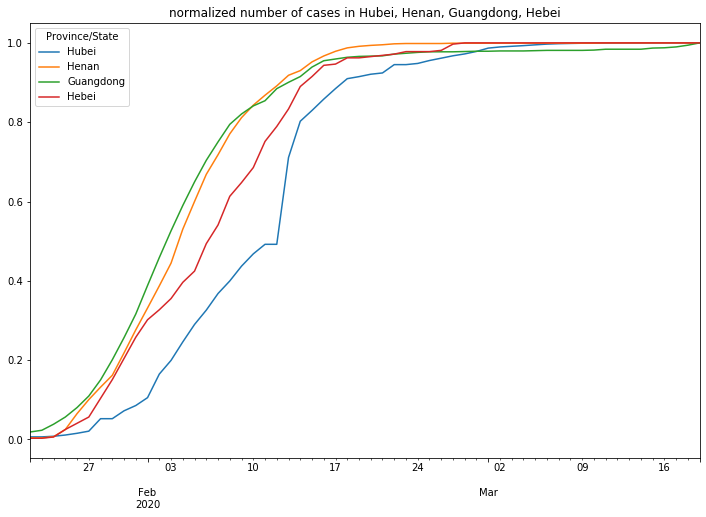

In [2]:
# plot provinces in china (normalized)

china_df = source_df[source_df["Country/Region"] == "China"]
china_df.set_index("Province/State", inplace=True)

timeseries_df = china_df.filter(regex='^[0-9/]+$', axis=1)
timeseries_df.columns = pd.to_datetime(timeseries_df.columns)

# normalize per-row by max
normalized_df = timeseries_df.apply(lambda x: x / x.max(), axis=1)
# normalized_df

provinces = ["Hubei", "Henan", "Guangdong", "Hebei"]
plot_df = normalized_df.loc[provinces].transpose()

plot_df.plot(figsize=(12, 8), legend=True, title="normalized number of cases in {}".format(", ".join(provinces)))


In [3]:
# squash countries and index with countries, produce normalized

country_df = source_df.groupby("Country/Region").sum()

country_df = country_df.filter(regex='^[0-9/]+$', axis=1)
country_df.columns = pd.to_datetime(timeseries_df.columns)

num_cases_cutoff = 100
country_df = country_df[country_df[country_df.columns[-1]] > num_cases_cutoff]

# normalize per-row by max
country_df_normalized = country_df.apply(lambda x: x / x.max(), axis=1)


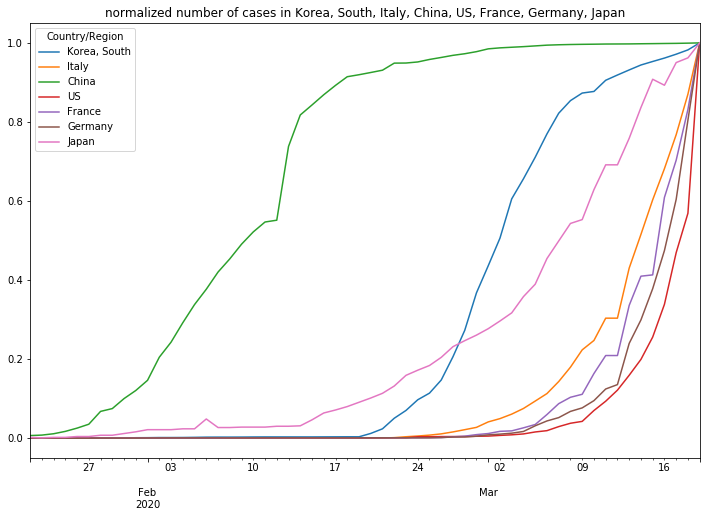

In [4]:
# plot countries (normalized)

# source_df["Country/Region"].unique()
# "Korea, South"
countries = ["Korea, South", "Italy", "China", "US", "France", "Germany", "Japan"]
countries_df = country_df_normalized.loc[countries]

plot_df = countries_df.transpose()
plot_df.plot(figsize=(12, 8), legend=True, title="normalized number of cases in {}".format(", ".join(countries)))

# Intuition:
# fit with the CDF of a Gaussian?
# Assumption is first derivative is Gaussian, each country has a lagged start.
# Fit the curve with "stabilized" countries and infer where the rest lies.


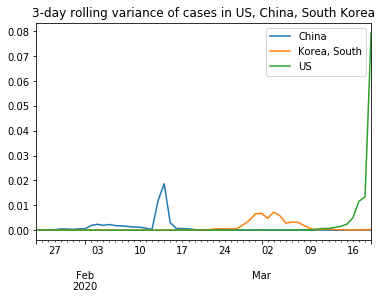

In [5]:
# investigate rolling variance as criteria for convergence

# expect the following two to be the same. Note the transpose
# print(country_df_normalized.transpose().rolling(3).var().dropna().transpose().loc["China"])
# print(country_df_normalized.loc["China"].rolling(3).var().dropna())

# rolling_var.loc["China"].plot()
# country_df_normalized["stabilized"] = rolling_var[-1]

country_df_normalized.loc["China"].rolling(3).var().dropna().plot(legend=True)
country_df_normalized.transpose().rolling(3).var().dropna().iloc[-1].transpose().head()

country_df_normalized.loc["Korea, South"].rolling(3).var().dropna().plot(legend=True)
country_df_normalized.loc["US"].rolling(3).var().dropna().plot(legend=True, title="3-day rolling variance of cases in US, China, South Korea")


In [6]:
# find converged countries
country_df_with_convergence = country_df_normalized.copy()
convergence_cutoff = 0.001

country_df_with_convergence["rolling_var"] = country_df_normalized.transpose().rolling(3).var().dropna().iloc[-1].transpose()
country_df_with_convergence["converged"] = country_df_with_convergence["rolling_var"] < convergence_cutoff

# converged countries
print("converged")
print(country_df_with_convergence.loc[country_df_with_convergence["converged"] == 1].index)

# growing countries
print("growing")
print(country_df_with_convergence.loc[country_df_with_convergence["converged"] == 0].index)


converged
Index(['China', 'Cruise Ship', 'Japan', 'Korea, South', 'Qatar', 'Slovenia'], dtype='object', name='Country/Region')
growing
Index(['Armenia', 'Australia', 'Austria', 'Bahrain', 'Belgium', 'Brazil',
       'Canada', 'Chile', 'Colombia', 'Croatia', 'Czechia', 'Denmark',
       'Ecuador', 'Egypt', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel',
       'Italy', 'Kuwait', 'Lebanon', 'Luxembourg', 'Malaysia', 'Mexico',
       'Netherlands', 'Norway', 'Pakistan', 'Panama', 'Peru', 'Philippines',
       'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino', 'Saudi Arabia',
       'Serbia', 'Singapore', 'Slovakia', 'South Africa', 'Spain', 'Sweden',
       'Switzerland', 'Taiwan*', 'Thailand', 'Turkey', 'US',
       'United Arab Emirates', 'United Kingdom'],
      dtype='object', name='Country/Region')


In [7]:
# time lag between two converged countries: time difference between peak of rolling variance

country_df_with_convergence["onset"] = country_df_normalized.transpose().rolling(3).var().dropna().idxmax()

country_onset = country_df_with_convergence.loc[country_df_with_convergence["converged"] == 1]["onset"]
lag_korea_china = country_onset['Korea, South'] - country_onset['China']

print("onset lag between Korea and China: {}".format(lag_korea_china))

onset lag between Korea and China: 18 days 00:00:00


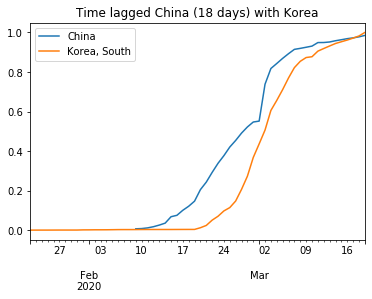

In [8]:
# time offset lagged Korea with China

countries = ["Korea, South", "China"]
countries_df = country_df_normalized.loc[countries]

shifted_df = country_df_normalized.loc["China"].shift(periods=lag_korea_china.days)

shifted_df.plot(legend=True)
country_df_normalized.loc["Korea, South"].plot(title="Time lagged China ({} days) with Korea".format(lag_korea_china.days), legend=True)


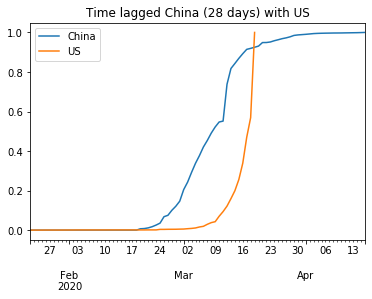

In [9]:
# attempt to time lag China to US

# arbitrary :(
shift_china_us = 28

later_df = pd.DataFrame(columns=pd.date_range(start=country_df_normalized.columns[-1], periods=shift_china_us + 1)[1:])

expanded_df = pd.concat([country_df_normalized, later_df])

expanded_df = expanded_df.loc["China"].shift(periods=shift_china_us, fill_value=0.0)
expanded_df.plot(legend=True)
country_df_normalized.loc["US"].plot(title="Time lagged China ({} days) with US".format(shift_china_us), legend=True)


Text(0.5, 1.0, 'Fit results: mu = 150.25,  std = 219.40')

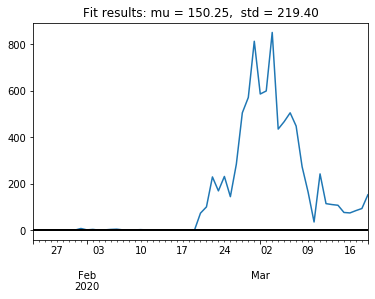

In [10]:
from scipy.stats import norm

country = "Korea, South"

gradient_df = country_df.diff(axis=1).iloc[:, 1:]
mu, std = norm.fit(gradient_df.loc[country])

gradient_df.loc[country].plot()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

# what's a good way to tell where in the slope we are a
